In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data = r"D:\Project\PG Project\Data\Image Data\seg_train\seg_train"
test_data = r"D:\Project\PG Project\Data\Image Data\seg_test\seg_test"

In [4]:
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [5]:
def load_data_and_extract_RF(data_dir, categories, image_size=(150, 150)):
    features = []
    labels = []
    for label, category in enumerate(categories):
        folder_path = os.path.join(data_dir, category)
        for file in tqdm(os.listdir(folder_path), desc=f"Loading {category}"):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, image_size)
            hog_feat = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), block_norm='L2-Hys')
            features.append(hog_feat)
            labels.append(label)
    return np.array(features), np.array(labels)

In [6]:
X_train, y_train = load_data_and_extract_RF(train_data, categories)
X_test, y_test = load_data_and_extract_RF(test_data, categories)

Loading street: 100%|██████████| 501/501 [00:12<00:00, 40.80it/s]


In [12]:
RF1 = RandomForestClassifier(n_estimators=100, random_state=42)
RF1.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
joblib.dump(RF1, 'RF_model_1')

['RF_model_1']

In [30]:
loaded_RF_model = joblib.load('RF_model_1')

In [52]:
y_pred = loaded_RF_model.predict(X_test)

In [56]:
print("📄 Classification Report (RF):")
print(classification_report(y_test, y_pred, target_names=categories, digits=6))

📄 Classification Report (RF):
              precision    recall  f1-score   support

   buildings   0.744949  0.675057  0.708283       437
      forest   0.806569  0.934461  0.865818       473
     glacier   0.518375  0.488160  0.502814       549
    mountain   0.485714  0.552581  0.516995       523
         sea   0.606061  0.549020  0.576132       510
      street   0.745263  0.706587  0.725410       501

    accuracy                       0.644170      2993
   macro avg   0.651155  0.650978  0.649242      2993
weighted avg   0.644215  0.644170  0.642413      2993



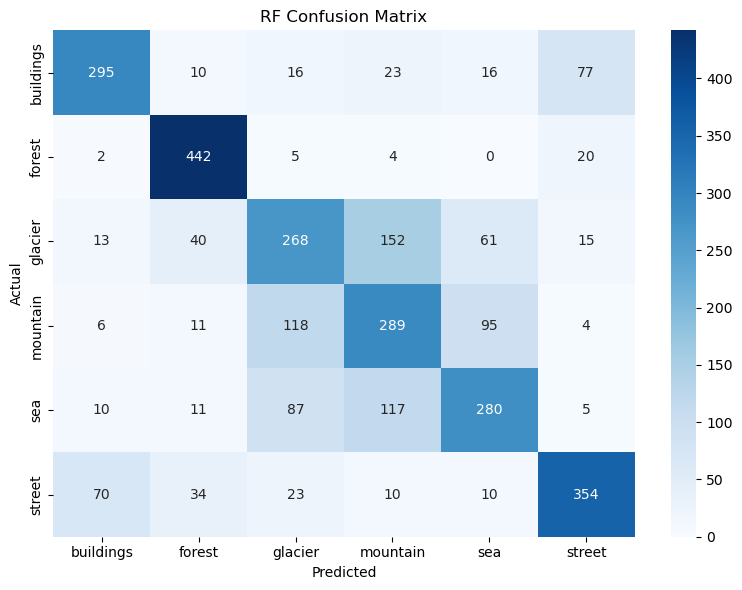

In [62]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title("RF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [46]:
def load_first_n_unlabeled_images(pred_dir, n=5, image_size=(150, 150)):
    features, paths, originals = [], [], []
    count = 0
    for filename in os.listdir(pred_dir):
        if filename.lower().endswith(('.jpg', '.png')):
            img_path = os.path.join(pred_dir, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, image_size)
            feat = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
            features.append(feat)
            paths.append(img_path)
            originals.append(img)
            count += 1
            if count >= n:
                break
    return np.array(features), paths, originals

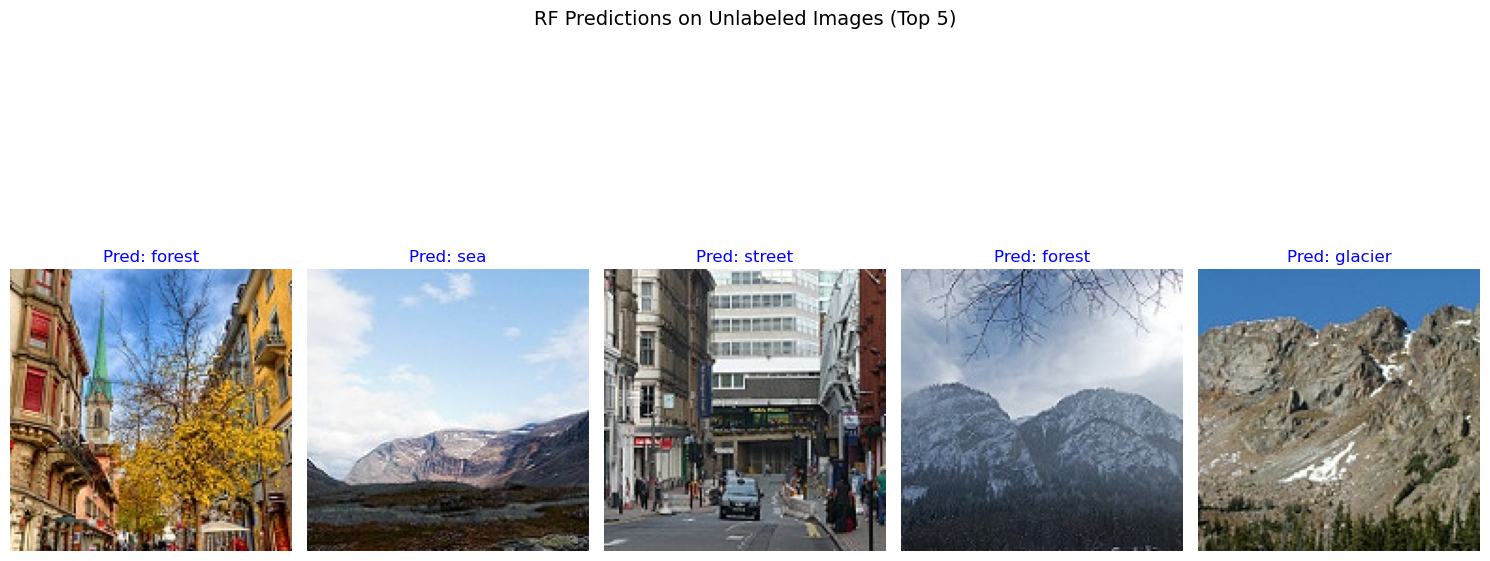

In [48]:
pred_dir = r'D:\Project\PG Project\Data\Image Data\seg_pred\seg_pred'
X_pred, pred_paths, original_images = load_first_n_unlabeled_images(pred_dir, n=5)

# 用 SVM 模型预测
y_pred_idx = loaded_RF_model.predict(X_pred)
y_pred_names = [categories[i] for i in y_pred_idx]

plt.figure(figsize=(15, 8))
for i in range(len(original_images)):
    img = original_images[i]
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {y_pred_names[i]}", color='blue', fontsize=12)
    plt.axis('off')

plt.suptitle("RF Predictions on Unlabeled Images (Top 5)", fontsize=14)
plt.tight_layout()
plt.show()

In [60]:
print("🌲 Number of trees:", len(loaded_RF_model.estimators_))

# 每棵树的最大深度
tree_depths = [estimator.tree_.max_depth for estimator in loaded_RF_model.estimators_]
print("🌲 Average tree depth:", np.mean(tree_depths))
print("🌲 Max tree depth:", np.max(tree_depths))

# 每棵树的叶子节点数
tree_leaves = [estimator.tree_.n_leaves for estimator in loaded_RF_model.estimators_]
print("🌿 Average number of leaves per tree:", np.mean(tree_leaves))

🌲 Number of trees: 100
🌲 Average tree depth: 44.88
🌲 Max tree depth: 58
🌿 Average number of leaves per tree: 2109.02
